# Исследование данных завода по производству б/а напитков

___

❗❗❗ __Внимание: Данные были изменены в целях сохранения Конфиденциальности и Коммерческой тайны__ ❗❗❗

___

## Цель
В рамках подготовки к квартальному ревью: <br>
Составить рекомендации для Начальника производства по устранению потерь, исходя из оценки результатов работы каждой смены и выявления источников наибольших потерь. 

## Задачи
Задача №1. Сравнить показатель эффективности (SLE) в разных сменах. <br>
Задача №2. Определить ключевые источники производственных потерь <br>


___

## Задача №1

Сравнить показатель эффективности (SLE) в разных сменах. <br>



<div class = "alert alert-block alert-info">
$$  SLE = \frac{ProductiveRunningTime - Validation - Maintenance}{ShiftDuration}*100% $$


In [ ]:
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt

In [43]:
# Статические переменные

DATA_FOLDER = '/Users/nikita/Desktop/git/data/' # Расположение файла с результатамии смен
DATA_FILENAME = 'EXPORT-2.xlsx'     # Имя файла с результатамии смен
SCHEDULE_FILENAME = 'schedule.xlsx' #  Расположение файла c графиком смен
production_lines = (207, 209, 296, 218, 233) #  Коды производственных линий 

In [44]:
# Функция загрузки данных в датафреймы

def load_data(DATA_FOLDER, DATA_FILENAME):     
    sv_results = pd.read_excel(DATA_FOLDER + DATA_FILENAME, parse_dates= True) #  Производственные данные   
    q1_schedule = pd.read_excel(DATA_FOLDER + SCHEDULE_FILENAME, parse_dates= True)  #  Графики смен
    return sv_results, q1_schedule


In [108]:
#  Функция для предобработки производственных данных. Оставляет только необходимые данные в удобном формате.
#  Расчитывает и добавляет в ДФ сведения о таких метриках как: 
#  Длительность, Время на валидацию и ТО, Чистое производственное время внутри смены 


def prepare_plant_data (sv_results):
    
    # Удаляю пустые колонки, оставляю только производственные линии
    sv_results.dropna(axis = 1, how = 'all', inplace=True)  
    sv_results = sv_results[sv_results['Work ctr'].isin(production_lines)] 
    
    
    # Переименовываю столбцы
    new_cols_names = {'Дата':'date', 'Work ctr':'line', 'Причина':'shift',      'Down-time code':'dt_code', 
                      'Down-time code desc.':'dt_desc', 'ОбщПродл':'shift_dur', 'Line hours':'action_dur'}    
    sv_results = sv_results.rename(columns=new_cols_names)
    
    
    # Нужные столбцы
    sv_results = sv_results[['date','line','shift','dt_code','dt_desc','shift_dur','action_dur']]
    
    
    # Привожу время к сек.
    sv_results.action_dur = sv_results.action_dur.apply(lambda x: x.second + x.minute * 60 + x.hour * 3600).copy() 
    
    
    # Перевожу формат даты в строковый, для унификации
    sv_results.date = sv_results.date.astype(str) 
    
    
    # Расчет чистого производственного времени (код 000) для каждой смены
    prod_time = sv_results[sv_results['dt_code'] == '000'] \
                .groupby(['date', 'shift'], as_index = False) \
                .agg({'action_dur':'sum'}) \
                .rename(columns= {'action_dur':'prod_time'})
    
    
    # Расчет времени, затраченного на валидацию и тех.обслуживание (код 95, 911) для каждой смены
    val_time = sv_results[sv_results['dt_code'].isin(['95', '911', '912'])] \
                .groupby(['date', 'shift'], as_index = False) \
                .agg({'action_dur':'sum'}) \
                .rename(columns= {'action_dur':'val_time'})
    
    
    # Расчет длительности каждой смены
    shift_time = sv_results.groupby(['date', 'shift'], as_index = False) \
                .agg({'action_dur':'sum'}) \
                .rename(columns= {'action_dur':'shift_time'})
    
    
    # Соединяю в одну таблицу длительность смены, время на валидацию и производственное время
    final_report = shift_time.merge(prod_time, on=['date', 'shift'], how='left') \
                .merge(val_time, on=['date', 'shift'], how='left') \
                .fillna(0) \
                .sort_values(by = ['date', 'shift'])
    
    return sv_results, final_report
    

In [52]:
# Функция подготавливает данные из графика смен к объединению с Данными

def prepare_shift_data (schedule):

    #  Для удобства транспонирую график смен
    schedule.drop(index=0,  inplace=True)
    schedule = schedule.transpose()
    
    
    # Выкидываю лишние строки
    schedule = schedule.drop(index = ['Ф.И.О.', 'Смена']).reset_index()
    schedule = schedule.set_axis(['date','Скифарь Игорь','Макаров Mаксим', 'Спальников Алексей', 
                                  'Турковский Сергей','Смирновский Александр'], axis = 1)
    
    
    # Сплитую колонки по-строчно, отсутствующие смены выкидываю
    schedule = schedule.melt(id_vars= 'date')
    schedule.dropna(how = 'any', inplace=True)
    schedule.reset_index().drop('index', axis=1, inplace=True)
    
    
    # День меняю на код P12M, ночь на P12N для унификации данных в таблицах
    schedule.replace({'Д':'P12M' , 'Н':'P12N'}, inplace=True)
    
    
    # Переименование столбца
    schedule.rename(columns={'value':'shift'}, inplace=True)
    
    
    # Перевожу формат даты в строковый, для унификации и беру первые 10 символов, то есть без времени
    schedule.date = schedule.date.astype(str)
    schedule.date = schedule.date.apply(lambda x: x[:10])
    
    
    return schedule


In [70]:
# Объединяю данные производства и график смен
# Расчитываю и добавляю в ДФ Долю метрик в общем результате

def supervisors_results(final_report, schedule):
    
    # Присоединяю таблицу с графиком смен к таблице с результатами смены
    result = final_report.merge(schedule, on = ['date', 'shift'], how = 'left')
    
    
    # Группирую по супервайзерам, 
    # Суммирую время чистого призводства, валидации и тех.обслуживания, общее производственное
    result = result.groupby('variable', as_index=False).agg({'shift_time':'sum', 'val_time':'sum', 'prod_time':'sum'})
    result['sle'] = round(result.prod_time / (result.shift_time - result.val_time) * 100, 1)
    result[['shift_time','val_time','prod_time']] = round(result[['shift_time','val_time','prod_time']] /3600, 0)
    result = result.rename(columns={'variable':'supervisor'})
    result['val_percent'] = result.val_time / result.shift_time * 100
    result = result.sort_values(by='sle', ascending=False).set_index('supervisor').reset_index()
    
    return result

In [109]:
sv_results, schedule = load_data(DATA_FOLDER, DATA_FILENAME) #  Выполнение функции Загрузки Данных
sv_results, final_report = prepare_plant_data(sv_results)  #  Выполнение функций Обработки данных
schedule = prepare_shift_data(schedule)        #  Выполнение функций Обработки Графика смен
result = supervisors_results(final_report, schedule)# Выполнение функции Объединения данных пр-ва и график смен


In [110]:
result

,supervisor,shift_time,val_time,prod_time,sle,val_percent
0,Скифарь Игорь,88.0,18.0,56.0,79.7,20.454545
1,Турковский Сергей,1569.0,663.0,648.0,71.6,42.256214
2,Смирновский Александр,1598.0,558.0,693.0,66.6,34.918648
3,Макаров Mаксим,1372.0,587.0,508.0,64.6,42.784257
4,Спальников Алексей,1349.0,461.0,550.0,61.9,34.173462


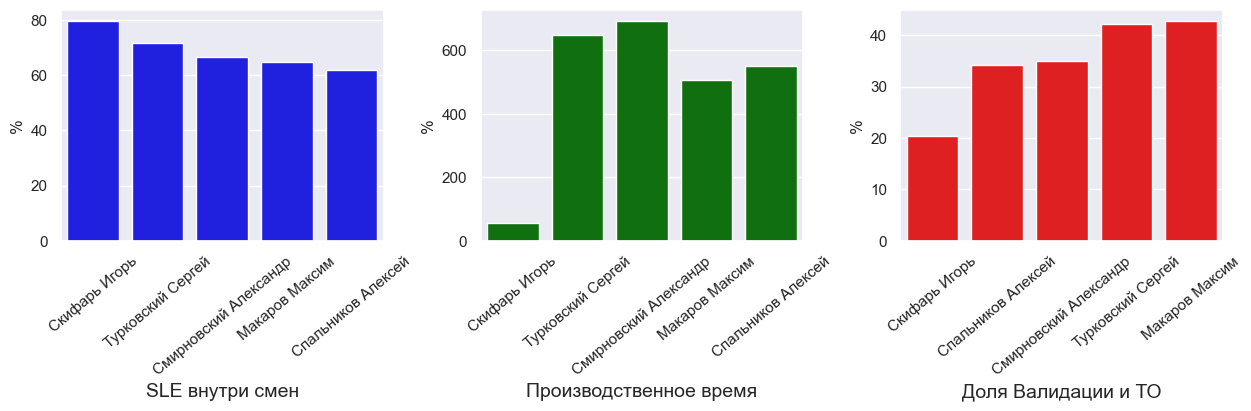

In [111]:
sns.set (rc={"figure.figsize":(15, 3)})
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(1,3,1)
sns.barplot(data = result, x = 'supervisor', y ='sle', color = 'blue')
plt.xticks(rotation=40);
plt.xlabel('SLE внутри смен', fontsize=14)
plt.ylabel('%')

plt.subplot(1,3,2)
sns.barplot(data = result, x = 'supervisor', y ='prod_time', color = 'green')
plt.xticks(rotation=40);
plt.xlabel('Производственное время', fontsize=14)
plt.ylabel('%')

plt.subplot(1,3,3)
sns.barplot(data = result.sort_values(by = 'val_percent'), x = 'supervisor', y ='val_percent', color = 'red')
plt.xticks(rotation=40);
plt.xlabel('Доля Валидации и ТО', fontsize=14)
plt.ylabel('%');


#  Заключение 
Скифарь - Старший Начальник смены, его результаты стоит оценить отдельно

<br>

__Среди остальных 4-х Начальников смен:__

👍 Турковский имеет наилучшие результаты по SLE, Чистому производственному времени, но имеет высокую долю валидации и ТО.

👍 Смирновский имеет сбалансированные результаты

⚠️ Спальников имеет низкий SLE  

⚠️ Макаров. низкий показатель SLE. К тому же имеет самую высокую долю Валидации и ТО.

<br>



____

## Задача №2.
Определить ключевые источники производственных потерь

#  Заключение 
Самая распрастранённая причина простоя - Техническая неисправность или операционные ошибки на филлере
Это наиболее проявляется на линиях 207, 209, 296, 233. <br>
На линии 218 - Наиболее часто Выходят из строя Паллетайзер и Упаковщик 


__Рекомендуется:__
1) запланировать комплексную проверку оборудования с привлечением специалистов <br>
2) Провести опрос среди операторов филлера и составить программу внепланового обучения


In [113]:
# Создаю ДФ с сгруппированныеми заводскими простоями. Время суммировано и переведено в часы

all_downtimes = sv_results.groupby(['line', 'dt_code','dt_desc'], as_index=False) \
    .agg({'action_dur':'sum'}) \
    .sort_values(by='action_dur', ascending=False)

all_downtimes.action_dur = all_downtimes.action_dur.apply(lambda x: round(x/60/60, 1)) 


In [187]:
# Функция записывает отчет по переданной производственной линии в файл с отчетом

def dt_report (all_downtimes, line_n):
    # Фильтр по линии
    plant_line = all_downtimes[all_downtimes.line == line_n]
    
    # Всё затраченное время
    paid_time = plant_line.action_dur.sum().round(1)
    
    # Чистое время производства
    productive_time = plant_line[plant_line.dt_code == '000'].action_dur.values[0]
    
    # Валидационное время (для вычета из SLE)
    validation_time = plant_line[plant_line.dt_code == '95'].action_dur.values[0]
    
    # Время на запланированное ТО (для вычета из SLE)
    maintenance_time = plant_line[plant_line.dt_code.isin(['912','911'])].action_dur.sum().round(1)
    
    # Net время 
    net_time = paid_time - validation_time - maintenance_time
    
    # Время на CIP процедуры
    cip_time = plant_line[plant_line.dt_code.isin(['11', '111', '15', '117', '115', '155', '53'])] \
               .action_dur.sum().round(1)

    # Создаю df с операционно-техническими простоями
    all_downtimes = plant_line[~plant_line.dt_code \
                    .isin(['11', '111', '15', '117', '115', '155', '53', '912', '911', '95', '000'])].copy() 
    
    # Суммарное время операционно-технических простоев
    downtime_dur = all_downtimes.action_dur.sum().round(1)
    
    # Расчет топ-5 простоев линии
    all_downtimes['dt_weight'] = plant_line['action_dur'] / net_time * 100
    all_downtimes = all_downtimes \
        .rename(columns = {'dt_desc':'Причина простоя', 'dt_weight':'%', 'action_dur':'Время'}) \
        .drop(['line', 'dt_code'], axis=1).set_index('Причина простоя')
    # Делаю формат выходных данных более читаемым
    all_downtimes['%'] = all_downtimes['%'].map('{:,.2f}%'.format)
    
    
    # Вывод отчета по линии    
    f = open("LINE_REPORT.txt", "a")
    
    f.write(f'''
    __________________________________________________________________________________________________
                                        
                                        Производственная линия {line_n} 
    
Paid_time   = {paid_time}(h)
Validation  = {validation_time}(h)    {round (validation_time / paid_time * 100, 2)}%
Maintenance = {maintenance_time}(h)    {round (maintenance_time / paid_time * 100, 2)}%
Netto time  = {net_time.round(1)}(h)   {round (net_time / paid_time * 100, 2)}%    

NET = {net_time.round(1)}(h)   100%    
SLE = {productive_time}(h)    {round (productive_time / net_time * 100, 2)}%
CIP = {cip_time}(h)    {round (cip_time / net_time * 100, 2)}%
DTs = {downtime_dur}(h)    {round (downtime_dur / net_time * 100, 2)}%


ТОП-5 Причин простоев на линии: 
{all_downtimes.head(5)}


''')

    
    f.close()
    
    return [line_n, validation_time, maintenance_time, productive_time, cip_time, downtime_dur]


In [193]:
# Очистить файл от прошлых отчетов
f = open("LINE_REPORT.txt", "w")
f.write('')
f.close()

df = pd.DataFrame(columns = ('line','validation_time','maintenance_time',
                             'productive_time','cip_time','downtime_dur'))

# Для каждой линии добавить запись о результатах в отчет
for line_n in production_lines: 
    lines = dt_report(all_downtimes, line_n)
    df.loc[len(df.index)] = lines

print('Отчет выгружен в REPORT.txt')
    

Отчет выгружен в REPORT.txt


#  Заключение 
Самая распрастранённая причина простоя - Техническая неисправность или операционные ошибки на филлере
Это наиболее проявляется на линиях 207, 209, 296, 233. <br>
На линии 218 - Наиболее часто Выходят из строя Паллетайзер и Упаковщик 


__Рекомендуется:__
1) запланировать комплексную проверку оборудования с привлечением специалистов <br>
2) Провести опрос среди операторов филлера и составить программу внепланового обучения


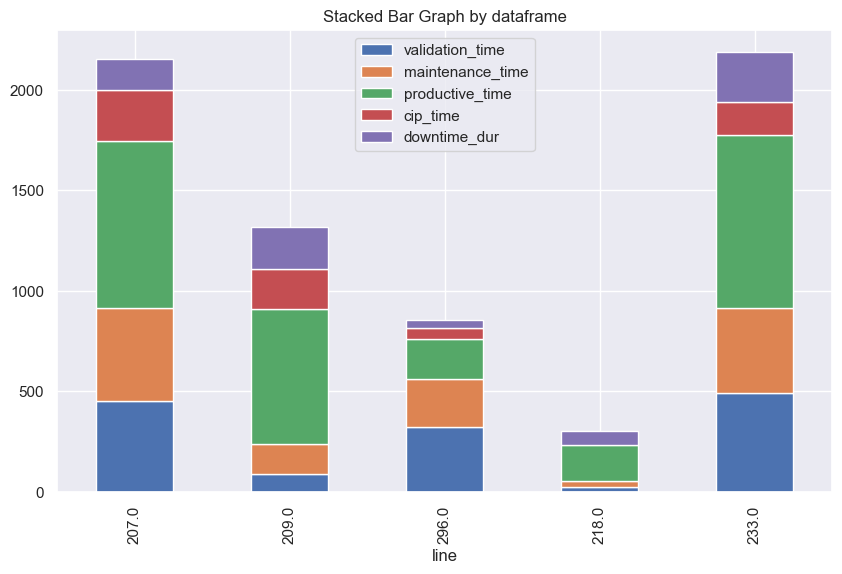

In [197]:
#  В Дополнение: Вот так выглядит сравнительный график нагруженности и эффективности линий

sns.set (rc={"figure.figsize":(10, 6)})
df.plot(x='line', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe')
plt.show()